In [374]:
import pandas as pd
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'lines.linewidth': 1, 'axes.labelsize': 12, 'axes.titlesize': 12})
sns.set_theme(style='whitegrid')
sns.set_context("notebook", rc={"lines.linewidth": 0.7})

palette = ["#e36414", "#588157", "#669bbc"]

In [375]:
results = Path('./slurm/results/')
sylvan_cudd_path = results / "229423" / "sylvan-cudd" 
sylvan_regression_path = results / "229422" / "sylvan-regression" 

def save(figure, name):
    figure.savefig(str(name) + ".svg", dpi=60, bbox_inches="tight")
    figure.savefig(str(name) + ".pgf", dpi=60, bbox_inches="tight")
    figure.clf()

In [376]:
sylvan_cudd_runtime = pd.read_csv(sylvan_cudd_path / 'sylvan_cudd_runtime.csv')
sylvan_cudd_quality = pd.read_csv(sylvan_cudd_path / 'sylvan_cudd_quality.csv')

In [377]:
sylvan_cudd_runtime.head()
# sylvan_cudd_quality.head()

,command,mean,stddev,median,user,system,min,max,model,reordering_trigger,solver,heuristic
0,./sylvan-solver -n 8 --nt 1 --tr 14 --ts 33 --...,0.658518,0.010407,0.660690,5.095611,0.098636,0.644970,0.679638,add16y.aag,sa,sylvan -n 8 --nt 1 --tr 14 --ts 33 --mg 1.2 --...,sift
1,./cudd-solver --h=sift --rt=sa ./models/add16y...,0.048271,0.003777,0.049109,0.039080,0.009173,0.037708,0.051233,add16y.aag,sa,cudd --h=sift,sift
2,./cudd-solver --h=group --rt=sa ./models/add16...,0.044670,0.001183,0.044348,0.034280,0.010365,0.043423,0.047013,add16y.aag,sa,cudd --h=group,group
3,./cudd-solver --rt=a --h=sift ./models/add18y...,0.077717,0.003741,0.078957,0.069912,0.007817,0.067193,0.079517,add18y.aag,a,cudd,sift
4,./cudd-solver --rt=a --h=group ./models/add18...,0.039472,0.004186,0.040235,0.027821,0.011665,0.027951,0.042736,add18y.aag,a,cudd,group


In [378]:
df = sylvan_cudd_quality
df = df.drop('workers', axis=1)
df = df.drop('nodes_threshold', axis=1)
df = df.drop('max_growth', axis=1)
df = df.drop('max_var', axis=1)
df = df.drop('max_swap', axis=1)

def derive_solver_type(row):
    if str(row["solver"]).__contains__("sylvan"):
        return "sylvan-sift"
    elif str(row["solver"]).__contains__("cudd"):
        if str(row["heuristic"]).__contains__("sift"):
            return "cudd-sift"
        elif str(row["heuristic"]).__contains__("group"):
            return "cudd-group"
    else:
        return "NaN"
        
df['Solver'] = df.apply(derive_solver_type, axis=1)
m = df[df["reordering_trigger"] == "m"]


m_add = m[m["model"].str.contains('add', na = False)]
m_mult = m[m["model"].str.contains('mult', na = False)]

m_add = m_add.sort_values(by=['Solver'])
m_mult = m_mult.sort_values(by=['Solver'])



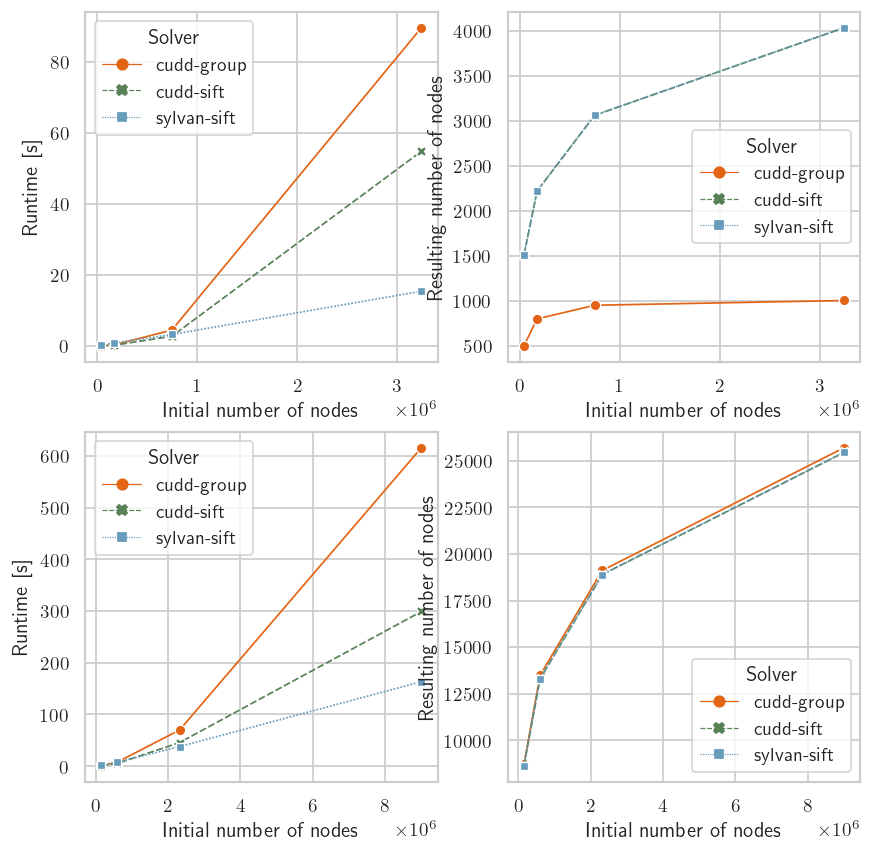

In [379]:
matplotlib.use("TkAgg")
%matplotlib inline

fig, axes = plt.subplots(2, 2, figsize=(8, 8), dpi=125)

def add_line_plot(
    ax, data, 
    x="from_size", y="time", 
    xlabel="Initial number of nodes", ylabel="Runtime [s]", 
    hue="Solver", style="Solver"):
    
    g = sns.lineplot(ax=ax, 
                 x=x, 
                 y=y, 
                 data=data, 
                 hue=hue, 
                 style=style, 
                 markers=True, 
                 dashes=True, 
                 palette=palette,
                 legend="auto",
                 linewidth=1
    )
    ax.set(xlabel=xlabel, ylabel=ylabel)
    return g
    
a = add_line_plot(
    ax=axes[0, 0], 
    y="time", 
    ylabel="Runtime [s]", 
    data=m_add)

b = add_line_plot(
    ax=axes[0, 1], 
    y="to_size", 
    ylabel="Resulting number of nodes", 
    data=m_add)

c = add_line_plot(
    ax=axes[1, 0], 
    y="time", 
    ylabel="Runtime [s]", 
    data=m_mult)

d = add_line_plot(
    ax=axes[1, 1], 
    y="to_size", 
    ylabel="Resulting number of nodes", 
    data=m_mult)

plt.show()

In [380]:
matplotlib.use("pgf")
plt.figure(figsize=(4,4))

def lineplot(
    data, 
    x="from_size", y="time", 
    xlabel="Given number of nodes", ylabel="Runtime", 
    hue="Solver", style="Solver"):
    
    g = sns.lineplot(
                 x=x, 
                 y=y, 
                 data=data, 
                 hue=hue, 
                 style=style, 
                 markers=True, 
                 dashes=True, 
                 palette=palette,
                 legend="auto",
                 linewidth=1
    )
    g.set(xlabel=xlabel, ylabel=ylabel)
    return g


    
lineplot(
    y="time", 
    ylabel="Runtime", 
    data=m_add)
save(plt, sylvan_cudd_path / 'sylvan-cudd-manual-runtime-add')
lineplot(
    y="to_size", 
    ylabel="Resulting number of nodes", 
    data=m_add)
save(plt, sylvan_cudd_path / 'sylvan-cudd-manual-quality-add')
lineplot(
    y="time", 
    ylabel="Runtime", 
    data=m_mult)
save(plt, sylvan_cudd_path / 'sylvan-cudd-manual-runtime-mult')
lineplot(
    y="to_size", 
    ylabel="Resulting number of nodes", 
    data=m_mult)
save(plt, sylvan_cudd_path / 'sylvan-cudd-manual-quality-mult')

manual_runtime_mult_table = m_mult.drop('reordering_trigger', axis=1)
manual_runtime_add_table = m_add.drop('reordering_trigger', axis=1)

manual_runtime_table = pd.concat([manual_runtime_mult_table, manual_runtime_add_table])
manual_runtime_table = manual_runtime_table.drop('solver', axis=1)
manual_runtime_table = manual_runtime_table.drop('heuristic', axis=1)
manual_runtime_table = manual_runtime_table.rename(columns={
    'from_size': 'Initial Size', 
    'to_size': 'Resulting Size',
    'time': 'Reordering Time [s]',
    'model': 'Model'
}) 

manual_runtime_table['Model'] = manual_runtime_table["Model"].apply(lambda x: f"{x}.aag")

manual_runtime_table = manual_runtime_table.reset_index(drop=True).set_index(['Model'])
manual_runtime_table = manual_runtime_table.sort_values(by=['Model'])

with open(sylvan_cudd_path / 'manual_runtime_table.tex', 'w') as tf:
     tf.write(manual_runtime_table.to_latex())
manual_runtime_table.head()

,Initial Size,Resulting Size,Reordering Time [s],Solver
Model,,,,
add10y.aag,38133,1510,0.247967,sylvan-sift
add10y.aag,38132,1509,0.030000,cudd-sift
add10y.aag,38132,500,0.040000,cudd-group
add12y.aag,169618,799,0.300000,cudd-group
add12y.aag,169618,2218,0.200000,cudd-sift


In [381]:
runtime = sylvan_cudd_runtime
runtime = runtime.drop('command', axis=1)
runtime = runtime.drop('user', axis=1)
runtime = runtime.drop('system', axis=1)
runtime = runtime[runtime["reordering_trigger"] != "m"]
runtime['solver_type'] = runtime.apply(derive_solver_type, axis=1)
runtime = runtime.sort_values(by=['solver_type'])
runtime = runtime[(runtime["solver_type"] == "sylvan-sift") | ((runtime["reordering_trigger"] == "a") & ( (runtime["solver_type"] == "cudd-sift") | (runtime["solver_type"] == "cudd-group") ))]
runtime = runtime.drop('solver', axis=1)
runtime = runtime.drop('heuristic', axis=1)

auto_runtime = runtime
auto_runtime = auto_runtime.rename(columns={'mean': 'Runtime [s]', 'model': 'Model', 'solver_type': 'Solver'})

auto_runtime.head()

,Runtime [s],stddev,median,min,max,Model,reordering_trigger,Solver
69,0.317135,0.005435,0.319585,0.306559,0.320947,mult_bool_matrix_2_3_9.aag,a,cudd-group
74,0.618906,0.001558,0.618639,0.617034,0.621532,mult_bool_matrix_2_3_11.aag,a,cudd-group
37,0.132637,0.003974,0.133463,0.121861,0.135499,mult_bool_matrix_2_3_6.aag,a,cudd-group
35,0.053753,0.001449,0.053764,0.051434,0.056479,add24y.aag,a,cudd-group
76,0.048626,0.000664,0.048477,0.047487,0.049692,add20y.aag,a,cudd-group


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Library/Frameworks/Python.framewor

<Axes: xlabel='Model', ylabel='Runtime [s]'>

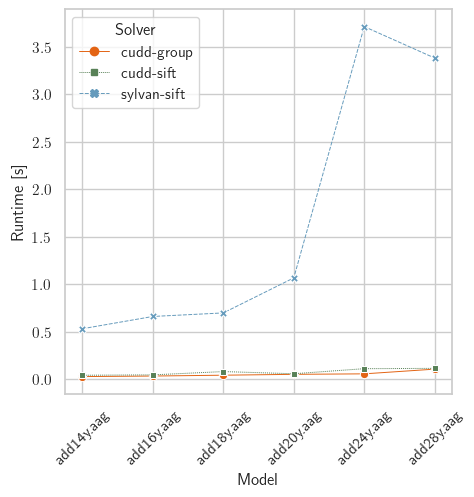

In [382]:
matplotlib.use("TkAgg")
%matplotlib inline

fig, ax = plt.subplots(figsize=(5,5))

locs, labels = plt.xticks()
plt.setp(labels, rotation=45)

auto_runtime_add = auto_runtime[auto_runtime["Model"].str.contains('add', na = False)]
auto_runtime_add = auto_runtime_add.sort_values(by=['Model'])

sns.lineplot(
    data=auto_runtime_add, 
    x="Model", 
    y="Runtime [s]", 
    hue="Solver",
    hue_order=["cudd-group","cudd-sift","sylvan-sift"], 
    errorbar='sd',
    palette = palette, 
    err_style='bars',
    style="Solver", 
    markers=True,
    dashes=True
)

In [383]:
matplotlib.use("pgf")
plt.figure(figsize=(5,5))
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)

auto_runtime_add = auto_runtime[auto_runtime["Model"].str.contains('add', na = False)]
auto_runtime_add = auto_runtime_add.sort_values(by=['Model'])

sns.lineplot(
    data=auto_runtime_add, 
    x="Model", 
    y="Runtime [s]", 
    hue="Solver",
    hue_order=["cudd-group","cudd-sift","sylvan-sift"], 
    errorbar='sd',
    palette = palette, 
    err_style='bars',
    style="Solver", 
    markers=True,
    dashes=True
)
save(plt, sylvan_cudd_path / 'sylvan-cudd-auto-runtime-add')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Library/Frameworks/Python.framewor

/var/folders/jk/3y1l63bd7_s1v1520g9714yr0000gn/T/ipykernel_48861/2530901123.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  auto_runtime_mult["Model"] = auto_runtime_mult.apply(rename_mult_model, axis=1)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = 

<Axes: xlabel='Model', ylabel='Runtime [s]'>

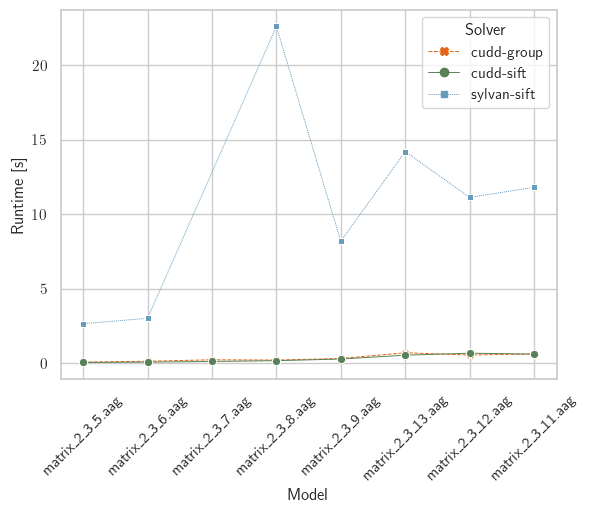

In [384]:
matplotlib.use("TkAgg")
%matplotlib inline
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)

def rename_mult_model(row):
    if str(row["Model"]).__contains__("mult"):
        return str(row["Model"]).split("bool_")[1]
    else:
        return row["Model"]
    
auto_runtime_mult = auto_runtime[auto_runtime["Model"].str.contains('mult', na = False)]
auto_runtime_mult["Model"] = auto_runtime_mult.apply(rename_mult_model, axis=1)
auto_runtime_mult = auto_runtime_mult.sort_values(by=['Runtime [s]'])
sns.lineplot(
    data=auto_runtime_mult, 
    x="Model", 
    y="Runtime [s]", 
    hue="Solver",
    hue_order=["cudd-group","cudd-sift","sylvan-sift"], 
    errorbar='sd',
    palette = palette, 
    err_style='bars',
    style="Solver", 
    markers=True,
    dashes=True
)

In [385]:
matplotlib.use("pgf")
plt.figure(figsize=(5,5))
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)

auto_runtime_mult = auto_runtime[auto_runtime["Model"].str.contains('mult', na = False)]
auto_runtime_mult["Model"] = auto_runtime_mult.apply(rename_mult_model, axis=1)
auto_runtime_mult = auto_runtime_mult.sort_values(by=['Runtime [s]'])
sns.lineplot(auto_runtime_mult, 
            x="Model", 
            y="Runtime [s]", 
            hue="Solver", 
            hue_order=["cudd-group","cudd-sift","sylvan-sift"],
            style="Solver", 
            palette = palette, 
            markers=True, dashes=False
)
save(plt, sylvan_cudd_path / 'sylvan-cudd-auto-runtime-mult')

/var/folders/jk/3y1l63bd7_s1v1520g9714yr0000gn/T/ipykernel_48861/984102678.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  auto_runtime_mult["Model"] = auto_runtime_mult.apply(rename_mult_model, axis=1)


In [386]:
auto_runtime_mult_table = auto_runtime_mult.drop('reordering_trigger', axis=1)
auto_runtime_mult_table = auto_runtime_mult_table.drop('Runtime [s]', axis=1)

auto_runtime_add_table = auto_runtime_add.drop('reordering_trigger', axis=1)
auto_runtime_add_table = auto_runtime_add_table.drop('Runtime [s]', axis=1)

auto_runtime_table = pd.concat([auto_runtime_add_table, auto_runtime_mult_table])
auto_runtime_table['Model'] = auto_runtime_table["Model"].apply(lambda x: f"mult_bool_{x}" if x.__contains__("matrix")  else x)

auto_runtime_table = auto_runtime_table.reset_index(drop=True).set_index(['Model'])
auto_runtime_table = auto_runtime_table.sort_values(by=['Model'])

with open(sylvan_cudd_path / 'auto_runtime_table.tex', 'w') as tf:
    tf.write(auto_runtime_table.style.to_latex(convert_css=True))
    
auto_runtime_table.head(10)

,stddev,median,min,max,Solver
Model,,,,,
add14y.aag,0.003243,0.024614,0.020467,0.028624,cudd-group
add14y.aag,0.016529,0.522284,0.517837,0.571502,sylvan-sift
add14y.aag,0.003793,0.039594,0.028569,0.042934,cudd-sift
add16y.aag,0.010407,0.660690,0.644970,0.679638,sylvan-sift
add16y.aag,0.005471,0.032964,0.022563,0.036607,cudd-group
add16y.aag,0.003988,0.043723,0.031790,0.045381,cudd-sift
add18y.aag,0.004186,0.040235,0.027951,0.042736,cudd-group
add18y.aag,0.010370,0.698470,0.680423,0.707584,sylvan-sift
add18y.aag,0.003741,0.078957,0.067193,0.079517,cudd-sift
